In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from tqdm import tqdm
from PIL import Image
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
path = "/content/drive/My Drive/Data/face-mask/"

# Load Data

In [ ]:
imgs = list(sorted(os.listdir(path + "images/")))
labels = list(sorted(os.listdir(path + "annotations/")))

In [ ]:
def generate_box(obj):

    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(path + "images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images and masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(path + "images/", file_image)
        label_path = os.path.join(path + "annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.is_available()

True

# Faster RCNN Model

Load Model

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Train Model

In [ ]:
num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    # i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(data_loader):
        # i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        # print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

  0%|          | 0/214 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
  0%|          | 0/214 [00:00<?, ?it/s]

tensor(89.1880, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(63.1003, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(52.8664, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(45.5636, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(40.4905, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(37.6214, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(33.0092, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(31.7557, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(29.6215, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(28.8139, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(24.7543, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(23.4304, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(27.7550, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(25.1378, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(24.3165, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(24.3861, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(23.0052, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(20.7806, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(20.8702, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(20.3748, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(24.4662, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(21.7791, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(21.5511, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/214 [00:00<?, ?it/s]

tensor(17.5730, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 214/214 [01:02<00:00,  3.40it/s]

tensor(17.8211, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[183.5432,  98.1392, 226.7381, 144.2443]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9947], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 19.9472,  71.7246,  43.0578,  92.7341],
          [223.9409,  36.0923, 259.7631,  75.1856],
          [317.2617,  32.8903, 352.7735,  71.1492],
          [297.6721,  57.8862, 313.8945,  81.5156],
          [192.6758,  64.6352, 215.9634,  95.2595],
          [143.2077,  73.2438, 172.4833, 114.5741],
          [144.4724,  74.0156, 173.3557, 109.9935],
          [318.3971,  32.4953, 354.8230,  65.8519]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9876, 0.9871, 0.9833, 0.9806, 0.9426, 0.9241, 0.6456, 0.0959],
         device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 71.3593,  41.0728,  99.6286,  70.4458],
          [153.3975,  48.3784, 

In [ ]:
# # kalo mau save model
# torch.save(model.state_dict(),path + 'frcnn_model.pt')
# # kalo mau load model
# model = get_model_instance_segmentation(3)
# model.load_state_dict(torch.load(path + 'frcnn_model.pt'))
# model.eval()
# model.to(device)

Plotting Image

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

Prediction


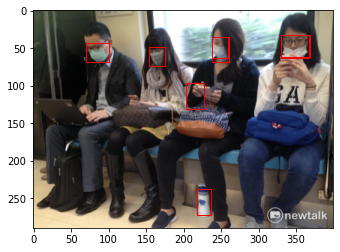

Target


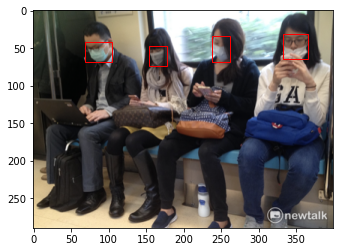

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

# Saving Weights

In [ ]:
torch.save(model.state_dict(), path+'weights/0311.pth')

In [ ]:
path

'/content/drive/My Drive/Data/face-mask/'